In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sales_forecasting.api.model import RequestSchema
from pydantic import parse_obj_as
from typing import List
import gc

from sales_forecasting.utils.feature_engineering import create_date_features, features_to_categorical

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [3]:
raw_sales_data = pd.read_csv('../data/sales_per_store_per_day.csv', 
    dtype={'Store':'Int64','DayOfWeek':'Int64','Sales':'Int64','Customers':'Int64','Open':'Int64','Promo':'Int64','StateHoliday':'str','SchoolHoliday':'Int64'},          parse_dates=['Date'])

raw_dict=raw_sales_data.to_dict(orient='records')
validated_sales=parse_obj_as(List[RequestSchema], raw_dict)

del raw_sales_data, raw_dict
gc.collect()

sales_df=pd.DataFrame([item.dict() for item in validated_sales])
del validated_sales 
gc.collect()

0

In [4]:
sales_df.head(5)

,sales_date,store,sales,customers,open_flag,promo,day_of_week,state_holiday,school_holiday
0,2015-06-30,1,5735,568,1,1,2,0,0
1,2015-06-30,2,9863,877,1,1,2,0,0
2,2015-06-30,3,13261,1072,1,1,2,0,1
3,2015-06-30,4,13106,1488,1,1,2,0,0
4,2015-06-30,5,6635,645,1,1,2,0,0


In [5]:
#apply  initial preprocessings
sales_df = create_date_features(sales_df, 'sales_date')
sales_df = features_to_categorical(sales_df)

In [6]:
print('At first glance at data, we can conclude below:\n')
print('Granularity of the table is at the date & store level')
print('There are {} distinct stores'.format(len(sales_df['store'].unique())))
print('First sales date is {}'.format(str(sales_df.sales_date.min())))
print('Last sales date is {}'.format(str(sales_df.sales_date.max())))

At first glance at data, we can conclude below:

Granularity of the table is at the date & store level
There are 1115 distinct stores
First sales date is 2013-01-01
Last sales date is 2015-06-30


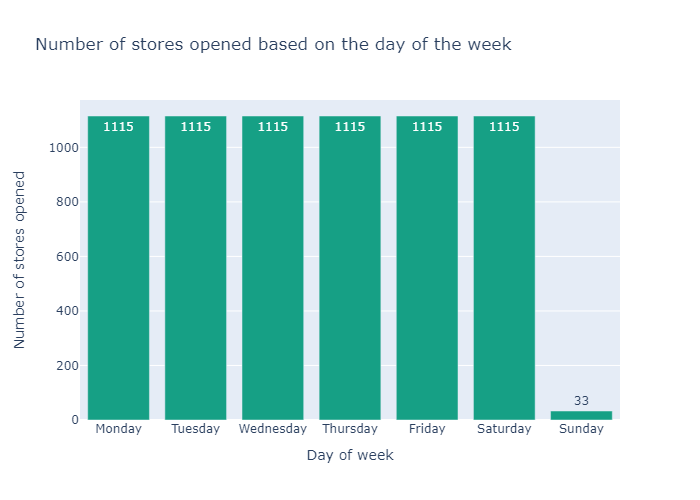

In [7]:
stores_opened_by_day_fig = go.Figure(data=
                                     go.Bar(
    x = pd.DataFrame(sales_df[sales_df['open_flag']==1].groupby(['week_day'])['store'].nunique()).reset_index()['week_day'],
    y = pd.DataFrame(sales_df[sales_df['open_flag']==1].groupby(['week_day'])['store'].nunique()).reset_index()['store'],
    marker_color='#16a085',
    text=pd.DataFrame(sales_df[sales_df['open_flag']==1].groupby(['week_day'])['store'].nunique()).reset_index()['store'],
    textposition='auto'
       ))
stores_opened_by_day_fig.update_layout(title='Number of stores opened based on the day of the week', xaxis_title='Day of week', yaxis_title='Number of stores opened')
stores_opened_by_day_fig.show("png")


Obs: the majority of the stores are closed on Sunday

In [8]:
pd.DataFrame(sales_df.groupby(['state_holiday','store'])['open_flag'].sum()).rename(columns={'open_flag':'no_days_store_is_open'})

no_days_store_is_open
state_holiday store                       
0             1                        754
              2                        755
              3                        752
              4                        757
              5                        749
...                                    ...
c             1111                       0
              1112                       0
              1113                       0
              1114                       0
              1115                       0

[4460 rows x 1 columns]

Obs: State holidays are not the same for all stores, which means, stores are from different counties or states in the case of USA

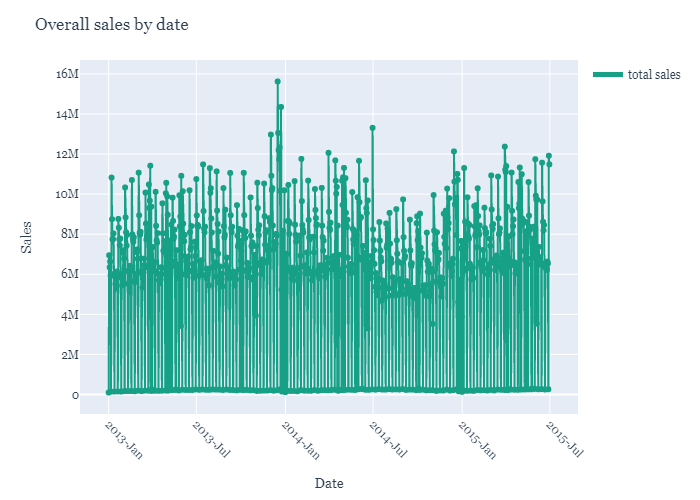

In [9]:
sales_by_date = sales_df.groupby('sales_date')['sales'].sum().reset_index()
fig = px.scatter(sales_by_date, x='sales_date', y='sales', color_discrete_sequence=['#16a085'])
fig.add_trace(go.Scatter(x=sales_by_date['sales_date'], y=sales_by_date['sales'], mode='lines', line=dict(color='#16a085', width=2), name='total sales'))
fig.update_layout(title='Overall sales by date', xaxis_title='Date', yaxis_title='Sales', font_family='Georgia', font_color='#2c3e50',
                  xaxis=dict(tickfont=dict(size=12), tickangle=45, tickformat='%Y-%b'), yaxis=dict(tickfont=dict(size=12)),
                  legend=dict(title=dict(text=''), itemsizing='constant', ))

fig.show("png")

From the above visualization, we can observe patterns on weekdays also a biweekly pattern (which most probably will be explained by the diversity of stores). Also, on Sundays, sales drop drastically, we can not take this as a global pattern on weekdays. Most probably there are a small set of stores which are open on Sundays too. Let’s identify them!

In [10]:
sales_by_date = sales_df.groupby('sales_date')['sales'].mean().reset_index()
fig = px.scatter(sales_by_date, x='sales_date', y='sales', color_discrete_sequence=['#16a085'])
fig.add_trace(go.Scatter(x=sales_by_date['sales_date'], y=sales_by_date['sales'], mode='lines', line=dict(color='#16a085', width=2), name='average sales'))
fig.update_layout(title='Average store level sales by date', xaxis_title='Date', yaxis_title='Sales',
                  font_family='Georgia', font_color='#2c3e50',
                  xaxis=dict(tickfont=dict(size=8), tickangle=45, tickformat='%Y-%b'), yaxis=dict(tickfont=dict(size=8)),
                  legend=dict(title=dict(text=''), itemsizing='constant'))
fig.show()

The plot above confirms the theory about non-stop stores.

Let’s calculated number of closed days by stores!

In [11]:
no_open_close_days_store = sales_df.groupby("store").agg(no_open_days=('open_flag', 'sum'),
                                                      no_closed_days=('close', 'sum')) \
                                           .reset_index()
no_open_close_days_store['close_percentage'] = no_open_close_days_store['no_closed_days'] / \
                                               (no_open_close_days_store['no_open_days'] + \
                                                no_open_close_days_store['no_closed_days'])

no_open_close_days_store = no_open_close_days_store.sort_values(by=['close_percentage'], ascending=False)

fig = go.Figure(data=[go.Table(header=dict(values=['Store', 'No open days', 'No closed days', 'Close %']),
                 cells=dict(values=[no_open_close_days_store['store'], 
                                    no_open_close_days_store['no_open_days'], 
                                    no_open_close_days_store['no_closed_days'], 
                                    no_open_close_days_store['close_percentage'].round(2)]))])

fig.update_layout(title="Store open/close days")
pio.show(fig)

We have 10 non-stop stores. Let’s split the data set into 2 and explore them separately

In [12]:
non_stop_stores = no_open_close_days_store.loc[no_open_close_days_store['close_percentage'] < 0.03, 'store']
sales_non_stop_stores = sales_df.loc[sales_df['store'].isin(non_stop_stores)]
sales_wo_non_stop_stores = sales_df.loc[~sales_df['store'].isin(non_stop_stores)]
plot_sales_non_stop_stores = sales_non_stop_stores.groupby('sales_date').agg({'sales': 'sum'}).reset_index()

fig1 = px.line(plot_sales_non_stop_stores, x='sales_date', y='sales', title='Summarised sales by date',
               labels={'sales_date': 'Date', 'sales': 'non-stop'})
fig1.update_traces(mode='markers+lines', marker=dict(size=3, color='#16a085'), line=dict(color='#16a085', width=2))
fig1.update_layout(template='plotly_white', xaxis=dict(tickformat='%Y-%b', dtick='M3'))

plot_sales_wo_non_stop_stores = sales_wo_non_stop_stores.groupby('sales_date').agg({'sales': 'sum'}).reset_index()
fig2 = px.line(plot_sales_wo_non_stop_stores, x='sales_date', y='sales', title='Summarised sales by date',
               labels={'sales_date': 'Date', 'sales': 'w/o non-stop'})
fig2.update_traces(mode='markers+lines', marker=dict(size=3, color='#16a085'), line=dict(color='#16a085', width=2))
fig2.update_layout(template='plotly_white', xaxis=dict(tickformat='%Y-%b', dtick='M3'), xaxis_title='')
fig2.update_layout(showlegend=False, title={'x': 0.5})

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)

fig.update_layout(title={'text': 'Sales data for non-stop stores vs. sales data excluding non-stop stores', 'x': 0.5},
                  font=dict(family='Georgia', size=12, color='#2c3e50'))

fig.update_xaxes(title_text='', row=1, col=1)
fig.update_yaxes(title_text='non-stop', row=1, col=1)
fig.update_yaxes(title_text='w/o non-stop', row=2, col=1)

fig.show()

Let’s check if there are stores with incomplete timeline

In [13]:
# compute stores with incomplete timeline
sales_df['sales_date'] = pd.to_datetime(sales_df['sales_date'])
stores_summary = (sales_df.groupby('store')
                        .agg(min_date=('sales_date', 'min'),
                             max_date=('sales_date', 'max'),
                             no_days=('sales_date', 'nunique'))
                        .assign(no_days_complete=lambda x: x['max_date'] - x['min_date'] + pd.Timedelta(days=1))
                        .reset_index())
stores_summary['no_days_complete'] = stores_summary['no_days_complete'].dt.days
stores_with_incomplete_timeline = stores_summary.loc[stores_summary['no_days'] < stores_summary['no_days_complete'], 'store']

# plot average store level sales by date for stores with incomplete timeline
sales_non_complete = sales_df.loc[sales_df['store'].isin(stores_with_incomplete_timeline)]
sales_non_complete = (sales_non_complete.groupby('sales_date')
                        .agg(sales_per_day=('sales', 'sum'),
                             no_stores_per_day=('open_flag', 'sum'))
                        .assign(avg_sales_per_store=lambda x: x['sales_per_day']/x['no_stores_per_day'])
                        .reset_index())
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_non_complete['sales_date'], y=sales_non_complete['avg_sales_per_store'],
                         mode='lines+markers', line=dict(color='blue', width=1)))
fig.update_traces(mode='markers+lines', marker=dict(size=3, color='#16a085'), line=dict(color='#16a085', width=2))
fig.update_layout(title='Average store level sales by date',
                  xaxis_title='Date',
                  yaxis_title='Sales')
fig.show()

There are 180 stores with incomplete timeline, we will need to treat them separately.

## Patterns in the date features

Let’s see if we can find visible patterns on the weekdays and months

In [14]:
sales_non_stop_stores_agg = sales_non_stop_stores.groupby(['week_day', 'month_day'])['sales'].mean().reset_index()

fig = go.Figure(data=[go.Heatmap(
                x=sales_non_stop_stores_agg['month_day'], y=sales_non_stop_stores_agg['week_day'], z=sales_non_stop_stores_agg['sales'], colorscale=[[0, "#ecf0f1"], [1, "#c0392b"]]
                )])
fig.update_layout(xaxis=dict(dtick=1, tickmode='linear'),
                  yaxis=dict(tickmode='linear'),
                  coloraxis_colorbar=dict(title='Average Sales'),
                  title='Average sales by Week Day & Month Day for non-stop stores',
                  xaxis_title='Month Day',
                  yaxis_title='Week Day'
                 )

fig.show()

In [15]:
sales_wo_non_stop_stores_agg = sales_wo_non_stop_stores.groupby(['week_day', 'month_day'])['sales'].mean().reset_index()

fig = go.Figure(data=[go.Heatmap(
                x=sales_wo_non_stop_stores_agg['month_day'],
                y=sales_wo_non_stop_stores_agg['week_day'],
                z=sales_wo_non_stop_stores_agg['sales'],
                colorscale=[[0, "#ecf0f1"], [1, "#c0392b"]]
                )])
fig.update_layout(xaxis=dict(tickvals=[i+1 for i in range(31)]),
                  yaxis=dict(tickmode='linear'),
                  coloraxis_colorbar=dict(title='Average Sales'),
                  title='Average sales by Week Day & Month Day w/o non-stop stores',
                  xaxis_title='Month Day',
                  yaxis_title='Week Day'
                 )
fig.show()

In [16]:
sales_by_store = sales_df.groupby(['year', 'month', 'store']).agg({'sales': 'sum'}).reset_index()
avg_sales_by_month = sales_by_store.groupby(['year', 'month']).agg({'sales': 'mean'}).reset_index()
avg_sales_by_month['year'] = avg_sales_by_month['year'].astype(str)

fig = go.Figure(data=[go.Heatmap( x=avg_sales_by_month['month'],
                  y=avg_sales_by_month['year'],
                  z=avg_sales_by_month['sales'],
                  colorscale=[[0, "#ecf0f1"], [1, "#c0392b"]]
                )])
fig.update_layout(xaxis=dict(tickformat='.0f'), 
                  title='Average sales by Year & Month',
                  xaxis_title='Month',
                  yaxis_title='Year')
fig.show()

## Store level metrics

In [17]:
sales = sales_df.assign(cust_sales = sales_df['sales'] / sales_df['customers']).groupby('store').agg(
        sales = pd.NamedAgg(column='sales', aggfunc='sum'),
        no_days = pd.NamedAgg(column='sales_date', aggfunc='nunique'),
        avg_day_sales = pd.NamedAgg(column='sales', aggfunc=lambda x: x.sum() / len(x)),
        avg_cust_sales = pd.NamedAgg(column='cust_sales', aggfunc='mean'),
        avg_no_cust = pd.NamedAgg(column='customers', aggfunc='mean')
    ).reset_index().sort_values('sales', ascending=False)


In [18]:
sales.head(10)

,store,sales,no_days,avg_day_sales,avg_cust_sales,avg_no_cust
261,262,18843209,911,20684.093304,6.049502,3400.414929
816,817,16494294,911,18105.701427,6.936269,2605.203074
561,562,16384004,911,17984.636663,5.765642,3106.592755
1113,1114,15575997,911,17097.691548,6.445458,2652.572997
250,251,14406561,911,15814.007684,7.763663,2028.017563
512,513,13786765,911,15133.660812,8.622359,1746.952799
732,733,13615364,911,14945.514819,4.395412,3403.448957
787,788,13601720,911,14930.537870,10.420560,1429.849616
382,383,13021837,911,14294.003293,7.802067,1824.591658
755,756,12464405,911,13682.113063,7.030120,1939.308452


## State & School Holidays

In [25]:
holidays_global = sales_df.groupby('sales_date').agg(
        avg_sales=('sales', 'sum'),
        no_open_stores=('open_flag', 'sum'),
        state_holiday=('state_holiday', lambda x: 1 if any(x != "0") else 0),
        school_holiday=('school_holiday', lambda x: 1 if any(x == 1) else 0)
    ).reset_index()

holidays_global['holiday'] = np.where(holidays_global['state_holiday']==1,1,holidays_global['school_holiday'])
holidays_global['avg_sales'] = holidays_global['avg_sales']/holidays_global['no_open_stores']

In [28]:
school_holidays = holidays_global.loc[holidays_global['school_holiday'] == 1, 'sales_date'].values
school_holidays = np.datetime_as_string(school_holidays, unit='D').tolist()
state_holidays = holidays_global.loc[holidays_global['state_holiday'] == 1, 'sales_date'].values
state_holidays = np.datetime_as_string(state_holidays, unit='D').tolist()

fig = px.line(holidays_global, x='sales_date', y='avg_sales', 
              title='Average store sales, state(dark grey) & school(light grey) holidays',
              labels={'sales_date': 'Date', 'avg_sales': 'Sales'},
              width=1000, height=500)


fig.add_trace(px.scatter(holidays_global, x='sales_date', y='avg_sales',
                 ).data[0])

for i in range(len(school_holidays)):
    fig.add_vline(x=school_holidays[i], fillcolor='grey', opacity=0.1)

for i in range(len(state_holidays)):
    fig.add_vline(x=state_holidays[i], fillcolor='grey', opacity=0.8)

fig.update_traces(mode='markers+lines', marker=dict(size=3, color='#16a085'), line=dict(color='#16a085', width=2))
fig.update_xaxes(
    dtick='M3',
    tickformat='%Y-%b',
    tickangle=0,
)

fig.show()

In [29]:
store_sales = sales_df[sales_df['store'] == 1]
store_school_holidays = store_sales[store_sales['school_holiday'] == 1]['sales_date'].values

store_school_holidays = np.datetime_as_string(store_school_holidays, unit='D').tolist()
store_state_holidays = store_sales[store_sales['state_holiday'] != '0']['sales_date'].values
store_state_holidays = np.datetime_as_string(store_state_holidays, unit='D').tolist()


fig = px.line(store_sales, x='sales_date', y='sales')
fig.update_layout(
    title="Average store sales, state(dark grey) & school(grey) holidays",
    xaxis_title="Sales",
    yaxis_title="Date",
    xaxis_tickformat='%Y-%b',
    xaxis=dict(
        tickmode='array',
        tickvals=pd.date_range(store_sales['sales_date'].min(), store_sales['sales_date'].max(), freq='3M').values.astype('int64') // 10**6,
        ticktext=pd.date_range(store_sales['sales_date'].min(), store_sales['sales_date'].max(), freq='3M').strftime('%Y-%b').tolist()
    )
)

for i in range(len(store_school_holidays)):
    fig.add_vline(x=store_school_holidays[i], fillcolor='grey', opacity=0.1)

for i in range(len(store_state_holidays)):
    fig.add_vline(x=store_state_holidays[i], fillcolor='grey', opacity=0.8)
fig.update_traces(mode='markers+lines', marker=dict(size=3, color='#16a085'), line=dict(color='#16a085', width=2))
fig.show()


## Promotions analysis

In [30]:
color_scale = [[0, "#fab1a0"], [1, "#1abc9c"]]

sales_summary = sales_df.loc[:, ["store", "week_day", "promo", "sales"]].groupby(["store", "week_day", "promo"]).mean().reset_index()
sales_summary["sales"] = sales_summary["sales"].replace(0, float("nan"))
sales_summary = sales_summary.groupby(["week_day", "promo"])["sales"].mean().reset_index()

fig = px.scatter(sales_summary, x="week_day", y="sales", color="promo", title="Average sales at store level by weekday & promotion", color_continuous_scale=color_scale )
fig.update_layout(xaxis_title="Week Day", yaxis_title="Sales", template="simple_white")
fig.show()


conclude that promotions are most efficient when they are organized at the begging of the week. Also, in most cases, when we saw higher sales on Mondays, can be explained by promotions.

## Variables correlogram

In [31]:
sales_df['state_holiday_flag'] = np.where(sales_df['state_holiday']=='0',0,1)
sales_for_corr = sales_df.loc[sales_df["open_flag"] == 1, ["sales", "year", "month", "month_day", "week_day", "promo", "state_holiday_flag", "school_holiday"]]
weekday_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
sales_for_corr['week_day'] = sales_for_corr['week_day'].map(weekday_dict).astype(int)
sales_for_corr["school_holiday"] = sales_for_corr["school_holiday"].astype(int)

corr = sales_for_corr.corr().round(2)
p_mat = np.tril(corr, k=-1)

fig = px.imshow(corr, color_continuous_scale=[[0, "#ecf0f1"], [1, "#c0392b"]], title="Correlogram of variables",
                labels=dict(x="", y="", color="Correlation"), x=list(corr.columns), y=list(corr.index),
                width=600, height=600)
fig.update_traces(showscale=True, reversescale=True)
fig.update_layout(title_font_size=20, font_size=15, title_font_family='Arial')
fig.show()